# MNIST convolutional neural networks

### A LeNet-5 like cnn MNIST classifier.

In [1]:
import time
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

######################
#  Slim을 사용할 것  #
slim = tf.contrib.slim
######################


In [2]:
sess_config = tf.ConfigProto(gpu_options = tf.GPUOptions(allow_growth=True))

np.random.seed(777)
tf.set_random_seed(777)

In [3]:
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.mnist.load_data()
train_data = train_data / 255.
train_labels = np.asarray(train_labels, dtype=np.int32)

test_data = test_data / 255.
test_labels = np.asarray(test_labels, dtype=np.int32)

print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)


(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


label =  3
(28, 28)


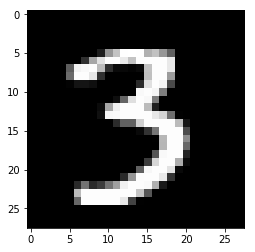

In [4]:
index = 10000
print("label = ",train_labels[index])
print(train_data[index].shape)
plt.imshow(train_data[index] , cmap='gray')
plt.show()

In [5]:
batch_size = 32

#for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.batch(batch_size = batch_size)
print(train_dataset)

#for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
test_dataset = test_dataset.shuffle(buffer_size = 10000)
test_dataset = test_dataset.batch(batch_size = len(test_data))
print(test_dataset)




<BatchDataset shapes: ((?, 28, 28), (?,)), types: (tf.float64, tf.int32)>
<BatchDataset shapes: ((?, 28, 28), (?,)), types: (tf.float64, tf.int32)>


In [6]:
handle = tf.placeholder(tf.string, shape=[])
iterator = tf.data.Iterator.from_string_handle \
                           (string_handle=handle, \
                            output_types=train_dataset.output_types, \
                            output_shapes=train_dataset.output_shapes) 

x, y = iterator.get_next()
x = tf.cast(x, dtype = tf.float32)
y = tf.cast(y, dtype = tf.int32)

일반적으로 TensorFlow 그래프는 수천 개에 이르는 많은 노드를 가질 수 있고 한 눈에 쉽게 보거나 보통의 그래프 도구를 이용해 그리기에는 너무 많음...

그래서 변수의 이름을 그룹으로 묶어서(name scoping) 계층화하는 방법을 사용할 수 있다.

처음에는 계층의 최상단에 있는 이름들만 보여지다가 노드를 클릭해서 펼치면 볼 수 있다.

여기 tf.name_scope를 사용해 "hidden"이라는
name scope 아래에 세 가지 기능을 정의한 예가 있습니다

```c
import tensorflow as tf

with tf.name_scope('hidden') as scope:
  a = tf.constant(5, name='alpha')
  W = tf.Variable(tf.random_uniform([1, 2], -1.0, 1.0), name='weights')
  b = tf.Variable(tf.zeros([1]), name='biases')
 ```
  
  위의 예시 코드의 결과로 아래와 같은 세 가지 연산(op)의 이름이 나오고
* 'hidden/alpha'
* 'hidden/weights'
* 'hidden/biases'

와 같이 확인이 가능


~~~
slim.conv2d()
tf.contrib.layers.conv2d(
    inputs,
    num_outputs,
    kernel_size,
    stride=1,
    padding='SAME',
    data_format=None,
    rate=1,
    activation_fn=tf.nn.relu,
    normalizer_fn=None,
    normalizer_params=None,
    weights_initializer=initializers.xavier_initializer(),
    weights_regularizer=None,
    biases_initializer=tf.zeros_initializer(),
    biases_regularizer=None,
    reuse=None,
    variables_collections=None,
    outputs_collections=None,
    trainable=True,
    scope=None
)
~~~

In [7]:
def cnn_model_fn(x):
    # Mnist라서 LeNet을 쓰지만 입력 크기는 다르다.
    with tf.name_scope('reshape'):
        x_image = tf.reshape(x, [-1,28,28,1])
        
    # Convolutional Layer #1
    # Input Tensor Shape: [batch_size, 28, 28, 1]
    # Output Tensor Shape: [batch_size, 28, 28, 32]
    conv1 = slim.conv2d(x_image, 32, [5,5], scope='conv1')
    #conv1 = tf.layers.conv2d(
    #    inputs=x_image,
    #    filters=32,
    #    kernel_size=[5, 5],
    #    padding="same",
    #    activation=tf.nn.relu)
    
    # Pooling Layer #1
    # Input Tensor Shape: [batch_size, 28, 28, 32]
    # Output Tensor Shape: [batch_size, 14, 14, 32]
    pool1 = slim.max_pool2d(conv1, [2, 2], scope='pool1')
    #pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    
    # Convolutional Layer #2
    # Input Tensor Shape: [batch_size, 14, 14, 32]
    # Output Tensor Shape: [batch_size, 14, 14, 64]
    conv2 = slim.conv2d(pool1, 64, [5,5], scope='conv2')
    
    # Pooling Layer #2
    # Second max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 14, 14, 64]
    # Output Tensor Shape: [batch_size, 7, 7, 64]
    pool2 = slim.max_pool2d(conv2,  [2,2], scope='pool2')
    
    # Flatten tensor into a batch of vectors
    # Input Tensor Shape: [batch_size, 7, 7, 64]
    # Output Tensor Shape: [batch_size, 7 * 7 * 64]
    pool2_flat = slim.flatten(pool2, scope='flatten')
    
    
    # 7 * 7 * 64 = 3136
    # (1 x 3136 ) (3136 X 1024 )
    # Fully connected Layer
    # Input Tensor Shape: [batch_size, 7 * 7 * 64]
    # Output Tensor Shape: [batch_size, 1024]
    fc1 = slim.fully_connected(pool2_flat, 1024, scope='fc1')
    #dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    
    # Add dropout operation; 0.6 probability that element will be kept
    is_training = tf.placeholder(tf.bool)
    fc1_drop = slim.dropout(fc1, keep_prob=0.6, is_training=is_training, scope='dropout')
    #dropout = tf.layers.dropout(inputs=dense, rate=0.4, training=is_training)

    # Logits layer
    # Input Tensor Shape: [batch_size, 1024]
    # Output Tensor Shape: [batch_size, 10]
    logits = slim.fully_connected(fc1_drop, 10, activation_fn=None, scope='logits')
  
    return logits, is_training, x_image
    

# Model을 빌드함

In [8]:
logits, is_training, x_image = cnn_model_fn(x)

# Define loss and optimizer

In [9]:
# 여기를 직접 채워 넣으시면 됩니다.
#y_one_hot = tf.one_hot(y, depth=10)
#cross_entropy = tf.losses.softmax_cross_entropy(onehot_labels=y_one_hot, logits=logits)
cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=y,
                                                       logits=logits)

train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

# 지정 tf.summary.FileWriter

In [10]:
train_dir = './graphs/train/'
print('Saving graph to: %s' % train_dir)
# 1. writer 객체 생성
train_writer = tf.summary.FileWriter(train_dir)

# 2. 그래프를 writer에 넣는다.
train_writer.add_graph(tf.get_default_graph())

Saving graph to: ./graphs/train/


In [11]:
with tf.name_scope('summaries'):
    # 3. tf.summary로  board에다가 그릴 것 넣기
    # tf.summary.scalar => loss 같은것
    # tf.summary.scalar => image
    # tf.summary.histogram => matrix
    tf.summary.scalar('loss/cross_entropy', cross_entropy)
    tf.summary.image('images', x_image)
    for var in tf.trainable_variables():
        tf.summary.histogram(var.op.name, var)
    # 4.  merge all summaries
    # 5. 넣은 것 all summary 하기
    summary_op = tf.summary.merge_all()

# tf.train.Saver
* tf.train.Saver.save(sess, save_path, global_step=None...)
* tf.train.Saver.restore(sess, save_path)

In [12]:
saver = tf.train.Saver()

# tf.Session() and train

In [13]:
# 1. writer 객체 생성
# 2. 그래프를 writer에 넣는다.
# 3. tf.summary로  board에다가 그릴 것 넣기
# 4. merge all summaries
# 5. 넣은 것 all summary 하기
# 6. sess.run할 때 summary 넣어주기
# 7. sess.run해서 나온 summary를 writer에 추가 , global step 지정   

In [ ]:
sess = tf.Session(config=sess_config)
sess.run(tf.global_variables_initializer())

# train_iterator
train_iterator = train_dataset.make_initializable_iterator()
train_handle = sess.run(train_iterator.string_handle())

# Train
max_epochs = 1
step = 0


for epochs in range(max_epochs):
    # 여기를 직접 채워 넣으시면 됩니다.
  sess.run(train_iterator.initializer)

  start_time = time.time()
  while True:
    try:
        # 여기를 직접 채워 넣으시면 됩니다.
      _, loss = sess.run([train_step, cross_entropy],
                          feed_dict={handle: train_handle,
                                    is_training: True})
      if step % 10 == 0:
        print("step: {}, loss: {}".format(step, loss))
        # 6. sess.run할 때 summary 넣어주기
        # summary를 sess.run
        summary_str = sess.run(summary_op,
                               feed_dict={handle: train_handle, is_training: False})
        # 7. sess.run해서 나온 summary를 writer에 추가 , global step 지정                        
        train_writer.add_summary(summary_str, global_step=step)
        
      step += 1

    except tf.errors.OutOfRangeError:
      print("  End of dataset")  # ==> "End of dataset"
      break

  # Save a model per every one epoch in periodically
  if epochs % 2 == 0:
    print("    Save model at {} epochs".format(epochs))
    saver.save(sess, train_dir + 'model.ckpt', global_step=step)
    
  print("  Epochs: {} Elapsed time: {}".format(epochs, time.time() - start_time))
  print("\n")

train_writer.close()
print("training done!")

step: 0, loss: 2.291449546813965
step: 10, loss: 2.140798568725586
step: 20, loss: 2.091951370239258
step: 30, loss: 1.8677887916564941
step: 40, loss: 1.5232555866241455
step: 50, loss: 1.3040505647659302
step: 60, loss: 0.8147233724594116
step: 70, loss: 0.7721024751663208
step: 80, loss: 0.8907058238983154
step: 90, loss: 0.7796086668968201
step: 100, loss: 0.6180256605148315
step: 110, loss: 0.6620495319366455
step: 120, loss: 0.5464301109313965
step: 130, loss: 0.4604496359825134
step: 140, loss: 0.20648175477981567
step: 150, loss: 0.2571292221546173
step: 160, loss: 0.40053844451904297
step: 170, loss: 0.8791305422782898
step: 180, loss: 0.25652989745140076
step: 190, loss: 0.20736101269721985
step: 200, loss: 0.32028090953826904
step: 210, loss: 0.3734211325645447
step: 220, loss: 0.2915639877319336
step: 230, loss: 0.3722003698348999
step: 240, loss: 0.5087811350822449
step: 250, loss: 0.4688178598880768
step: 260, loss: 0.39242827892303467
step: 270, loss: 0.17259420454502106

In [ ]:
test_batch_size = 16
batch_index = np.random.choice(len(test_data), size=test_batch_size, replace=False)
batch_xs = test_data[batch_index]
y_pred = sess.run(logits, feed_dict={x: batch_xs, is_training: False})

fig = plt.figure(figsize=(16, 10))
for i, (px, py) in enumerate(zip(batch_xs, y_pred)):
  p = fig.add_subplot(4, 8, i+1)
  p.set_title("y_pred: {}".format(np.argmax(py)))
  p.imshow(px.reshape(28, 28), cmap='gray')
  p.axis('off')
